# YOLOv2 on PYNQ-Z1 and Movidius NCS: Image example
This example tests the YOLO network with an image file. See this guide to [setup your PYNQ-Z1 for the Movidius NCS](http://www.fpgadeveloper.com/2018/04/setting-up-the-pynq-z1-for-the-intel-movidius-neural-compute-stick.html).
### Load required packages

In [1]:
import cv2
import numpy as np
import time
import PIL.Image
from matplotlib import pyplot as plt
%matplotlib inline 

import sys
sys.path.insert(0, '../detectionExample')

from ObjectWrapper import *
from Visualize import *

### Open the Movidius NCS

In [2]:
# Open the Movidius NCS device
detector = ObjectWrapper('../graph')

### Load the image

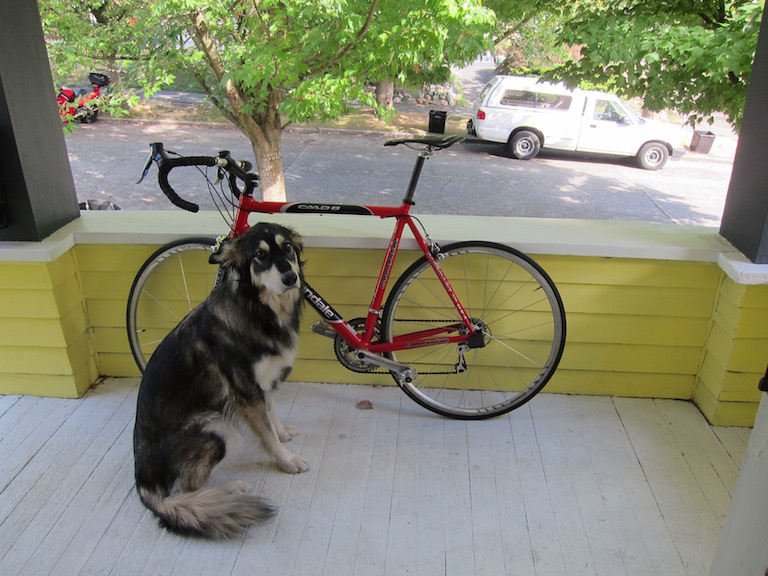

In [3]:
frame = cv2.imread('../data/dog.jpg')
frame = frame[:,:,(2,1,0)]

# Display image in Jupyter notebook
img = PIL.Image.fromarray(frame)
img

### Calculate image resizing factors

In [4]:
# YOLOv2 input frame dimensions
dim = detector.dim

imgw = frame.shape[1]
imgh = frame.shape[0]
ncs_frame = np.empty((dim[0], dim[1], 3))
ncs_frame.fill(0.5)

if imgh/imgw > dim[1]/dim[0]:
    neww = int(imgw * dim[1] / imgh)
    newh = dim[1]
else:
    newh = int(imgh * dim[0] / imgw)
    neww = dim[0]
offx = int((dim[0] - neww)/2)
offy = int((dim[1] - newh)/2)

# X offset of the image WRT the original image size
offx_orig = int(offx*imgw/neww)
# Y offset of the image WRT the original image size
offy_orig = int(offy*imgh/newh)
# Horizontal scale factor
xscale = neww/dim[0]
# Vertical scale factor
yscale = newh/dim[1]

print('offx_orig:',offx_orig,'offy_orig:',offy_orig,'xscale:',xscale,'yscale:',yscale)

offx_orig: 0 offy_orig: 96 xscale: 1.0 yscale: 0.75


###### Resize the image to the size required by the YOLO network (416x416)

Runtime: 0.11723685264587402


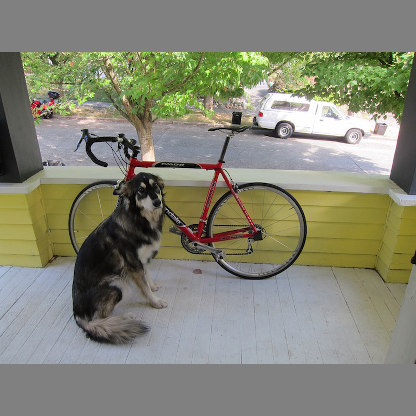

In [5]:
start_time = time.time()

# Resize the frame, keeping the proportions the same
small_frame = cv2.resize(frame, dsize=(neww, newh), interpolation=cv2.INTER_CUBIC)
ncs_frame[offy:offy+newh,offx:offx+neww,:] = small_frame.copy()/255.0

end_time = time.time()
print('Runtime:',end_time-start_time)

# Display image in Jupyter notebook
img = PIL.Image.fromarray(np.around(ncs_frame*255.0).astype(np.uint8))
img

### Send image to the NCS

Runtime: 0.2830195426940918


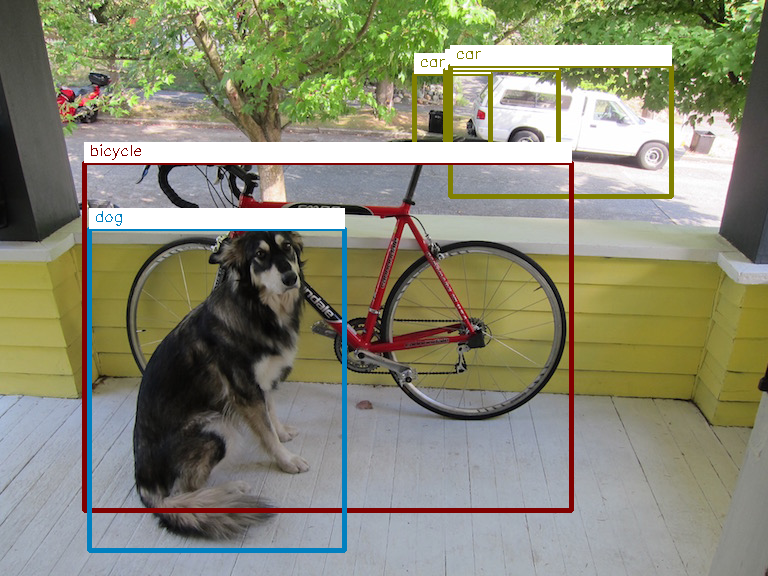

In [6]:
start_time = time.time()

results = detector.DetectFromPreparedImage(ncs_frame,imgw,imgh,offx_orig,offy_orig,xscale,yscale)

end_time = time.time()

print ('Runtime:',end_time-start_time)

# Interpret results and draw boxes on the image
img_res = Visualize(frame, results)

# Display image in Jupyter notebook
img = PIL.Image.fromarray(img_res)
img


### Close the NCS device

In [7]:
del detector